#**Image Captioning**
*  Converting Image to a text.
*   Works as visual Aid for blind people.




In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers import Add  # Capital A

In [9]:
!dir

In [10]:
# read text captions

def readTextFile(path):
    with open(path) as f:
        caption = f.read()
    return caption

In [11]:
captions = readTextFile('/kaggle/input/flicker/captions.txt')

In [12]:
captions = captions.split('\n')[:-1]

In [13]:
captions[161]

'1042020065_fb3d3ba5ba.jpg,A boy in a green shirt is looking down at many inflatable boats .'

In [14]:
desc = {}

for x in captions:
    zyzz = x.split(',')
    img_name,img_captions= zyzz[0],zyzz[1]

    if desc.get(img_name) is None:
        desc[img_name] = []
    desc[img_name].append(img_captions)

In [15]:
desc['1000268201_693b08cb0e.jpg']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [16]:
import cv2

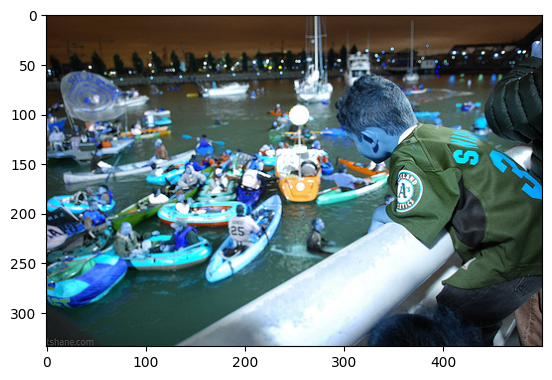

['A boy in a green shirt is looking down at many inflatable boats .',
 'A boy in a green shirt watches kayakers .',
 'A boy looks over a railing at the many boats and rafts below in the water .',
 'A young boy overlooking a crowd of inflatable boats .',
 'A young boy wearing a jersey looks down over a ledge at many boats in the water .']

In [17]:
path = '/kaggle/input/flicker/Flickr8k_Dataset/Flicker8k_Dataset/1042020065_fb3d3ba5ba.jpg'
plt.imshow(cv2.imread(path))
plt.show()
desc['1042020065_fb3d3ba5ba.jpg']

# Data Cleaning
**HERE**

* Not removing stopwords
* Not doing stemming
* Only removing numbers, punctuations





In [18]:
import re

In [19]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub('[^a-z]+',' ', sentence)
    sentence = sentence.split()
    sentence = [s for s in sentence if len(s) > 1]
    sentence = ' '.join(sentence)
    return sentence

In [20]:
# cleaning all captions

In [21]:
for key, caption_list in desc.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [22]:
desc['1042020065_fb3d3ba5ba.jpg']

['boy in green shirt is looking down at many inflatable boats',
 'boy in green shirt watches kayakers',
 'boy looks over railing at the many boats and rafts below in the water',
 'young boy overlooking crowd of inflatable boats',
 'young boy wearing jersey looks down over ledge at many boats in the water']

In [23]:
# write the data to text file
with open('/content/descriptions_1.txt','w') as f:
    f.write(str(desc))

# Vocabulary
* It is a set of all possible unique words that model can predict.





In [24]:
import json

In [25]:
descriptions = None

with open('/kaggle/input/flicker/descriptions_1.txt') as f:
    descriptions = f.read()
json_acceptable_string = descriptions.replace("'","\"")
descriptions = json.loads(json_acceptable_string)

In [26]:
# descriptions
print(type(descriptions))

<class 'dict'>


In [27]:
descriptions.get('1042020065_fb3d3ba5ba.jpg')

In [28]:
# Vocab

vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]

print("Vocab Size(unique words In Vocab) : %d"% len(vocab))

Vocab Size(unique words In Vocab) : 8257


In [29]:
vocab = set()
vocab.update(["hello", "apple"])
vocab.update(["hello"])
vocab.update(["hi"])
print(vocab)

{'apple', 'hi', 'hello'}


In [30]:
descriptions.get('1042020065_fb3d3ba5ba.jpg')

In [31]:
# Total No of words across all the sentences
total_words = []

for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]

print("Total Words %d"%len(total_words))

Total Words 357791


In [32]:
len(total_words), type(total_words)

(357791, list)

In [33]:
# filter words from vocab according to certain threshold frequency
import collections
counter = collections.Counter(total_words)
frq_cnt = dict(counter)
print(len(frq_cnt.keys()))
# print(frq_cnt)

8257


In [34]:
# sort the dictionary according to the freq count

sorted_freq_cnt = sorted(frq_cnt.items(), reverse = True, key=lambda x:x[1])

# filter
threshold =  10
sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]

In [35]:
#sorted_freq_cnt
print(len(total_words)) # 1800 unique words filter, this is going to be new vocab size

1800


In [36]:
descriptions.get('1042020065_fb3d3ba5ba.jpg')

# Train/Test Data

In [37]:
len(descriptions.keys()), len(descriptions.values())

(8091, 8091)

In [38]:
train_file_data = readTextFile('/kaggle/input/flicker-text/Flickr_8k.trainImages.txt')
test_file_data = readTextFile('/kaggle/input/flicker-text/Flickr_8k.testImages.txt')

In [39]:
train = [row.split('.')[0] for row in train_file_data.split('\n')[:-1]]
test = [row.split('.')[0] for row in test_file_data.split('\n')[:-1]]

In [40]:
len(train), len(test)

(6000, 1000)

In [41]:
print(descriptions.get('1000268201_693b08cb0e.jpg'))

None


In [42]:
train[:5]

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87']

In [43]:
# Prepare Description for the Training Data
# Tweak - Add <s> and <e> token to our training data
train_descriptions = {}
for img_id in train:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id]:
        cap_to_append = "startseq " + cap + " endseq"
        train_descriptions[img_id].append(cap_to_append)

In [44]:
train_descriptions["1000268201_693b08cb0e"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

# Transfer Learning

In [66]:
# from keras.applications.resnet50 import ResNet50

# model = ResNet50(
#     weights='/kaggle/input/uploading/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
#     include_top=False,
#     input_shape=(224, 224, 3)
# )

# Build model with pooling
from keras.applications import ResNet50
from keras.models import Model
from keras.layers import GlobalAveragePooling2D

model = ResNet50(
    weights='/kaggle/input/uploading/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
    include_top=False,
    input_shape=(224, 224, 3)
)

x = GlobalAveragePooling2D()(model.output)
model_new = Model(inputs=model.input, outputs=x)


model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [67]:
# model_new = Model(model.input,model.layers[-2].output)

In [68]:
def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Normalisation
    img = preprocess_input(img)
    return img

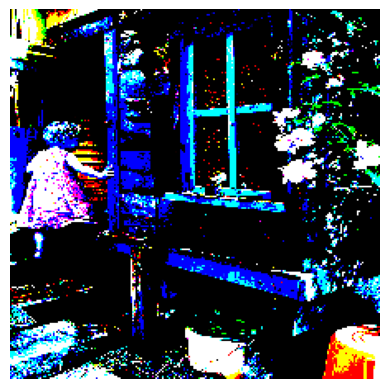

In [69]:
img = preprocess_img("/kaggle/input/flicker/Flickr8k_Dataset/Flicker8k_Dataset/1000268201_693b08cb0e.jpg")
plt.imshow(img[0])
plt.axis("off")
plt.show()

In [71]:
def encode_image(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape((2048,))
    #print(feature_vector.shape)
    return feature_vector

In [72]:
encode_image("/kaggle/input/flicker/Flickr8k_Dataset/Flicker8k_Dataset/1000268201_693b08cb0e.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


array([0.06536549, 0.1678271 , 0.32518435, ..., 0.05111533, 0.32817906,
       1.0043344 ], dtype=float32)

In [73]:
type(train)

list

In [ ]:
start = time()
encoding_train = {}
#image_id -->feature_vector extracted from Resnet Image
for ix,img_id in enumerate(train):
    img_path = '/kaggle/input/flicker/Flickr8k_Dataset/Flicker8k_Dataset'+"/"+img_id+".jpg"
    encoding_train[img_id] = encode_image(img_path)
    if ix%100==0:
        print("Encoding in progress time step %d "%ix)
end_t = time()
print("Total Time Taken :",end_t-start)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
Encoding in progress time step 0 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12